In [1]:
from p5control import DataGateway, InstrumentGateway
import numpy as np

gw = InstrumentGateway()
dgw = DataGateway()

gw.connect()
dgw.connect()

In [4]:
type(max([0, -100]))

int

In [3]:
from core.scripts.sweeps import Sweeps
sweeper = Sweeps('sweeps')
sweeper.setOffsetTime(2)

In [13]:

sweeper.get_offset()

In [12]:
bin_volt, bin_curr_down, bin_curr_up= sweeper.get_sweeps()

[0.46071512] [-0.04339647]
0.29930684 -0.15607964
V, C (t)
-0.0010282209 0.0010337648
-1.4639866e-08 1.39911895e-08
10
[  9 505] [257]
ups and downs
-0.001015813322737813 0.0010050330311059952
-0.0009904894977807999 0.00103376479819417
-1.419413298009431e-08 1.389222958891878e-08
-1.4108976209570301e-08 1.3991189540263349e-08
binned
-0.002 0.002
-1.4108976209570301e-08 1.3991189540263349e-08
-1.419413298009431e-08 1.3849330571247265e-08


array([-0.002   , -0.001998, -0.001996, ...,  0.001996,  0.001998,
        0.002   ])

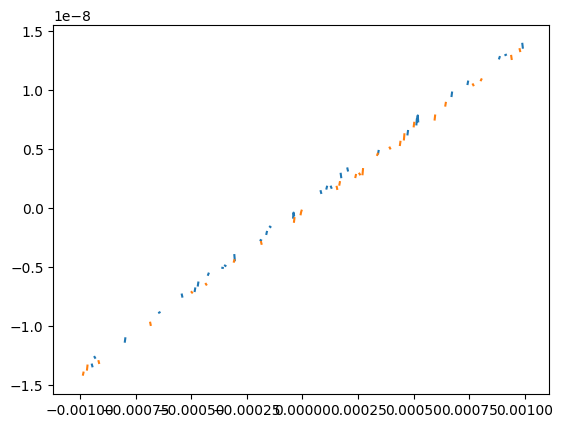

In [8]:
import matplotlib.pyplot as plt
plt.plot(bin_volt, bin_curr_up)
plt.plot(bin_volt, bin_curr_down)
bin_volt

In [12]:
from p5control.scripts.sweeps import Sweeps
sweeper = Sweeps('offset')
sweeper.setOffsetTime(.1)

In [39]:
dgw.get('/status').name

'/status'

# Messskripte in Kürze

In [4]:
from time import sleep, time
from scipy.signal import savgol_filter as sg
from scipy.signal import find_peaks as fp
from scipy.optimize import curve_fit
import numpy as np


# Pre - Definitions

def get_dataset(dgw, tic, toc, multi_keyword, hdf5_path='m000000'):
    # TODO slices
    multi = dgw.get_data(f"/measurement/{hdf5_path}/multi_{multi_keyword}/")
    time, V = multi['time'], multi['V']
    indices = np.argmin(np.abs(time-tic)), np.argmin(np.abs(time-toc))
    return time[indices[0]:indices[1]], V[indices[0]:indices[1]]

def get_min_max_peaks(V, t, frequency, sweep_counts):
    window_length = int(10/frequency)
    smooth_V = sg(V, window_length=window_length, polyorder=1)
    dV = np.gradient(smooth_V)
    smooth_dV = sg(dV, window_length=window_length, polyorder=1)
    ddV = np.gradient(smooth_dV)
    smooth_ddV = sg(ddV, window_length=window_length, polyorder=1)

    symmetrical_ddV = smooth_ddV - np.mean(smooth_ddV)

    min_peaks = fp(symmetrical_ddV, height=.25*np.nanmax(symmetrical_ddV), distance=2*window_length)[0]
    max_peaks = fp(-symmetrical_ddV, height=.25*np.nanmax(symmetrical_ddV), distance=2*window_length)[0]

    if len(min_peaks) == len(max_peaks):
        min_peaks = np.append(min_peaks, [-1])
    return min_peaks, max_peaks

def get_up_down_sweep(array, mins, maxs):
    up = np.array([])
    down = np.array([])
    for i, p in enumerate(maxs):
        up = np.append(up, array[mins[i]:p])
        down = np.append(down, array[p:mins[i+1]])
    return up, down

def get_binned_current(voltage, current, bins):
    bins = np.append(bins, 2 * bins[-1] - bins[-2])
    _count, _ = np.histogram(voltage,
                            bins = bins,
                            weights=None)
    _count = np.array(_count, dtype='float64')
    _count[_count==0] = np.nan
    _sum, _ = np.histogram(voltage,
                        bins =bins,
                        weights=current)
    return _sum/_count

def calc_rms(x):
    return np.sqrt(np.nanmean(np.abs(x)**2))
    
def lin_fit_1(V, R, I_0_1, I_0_2):
        return V / R + I_0_1

def lin_fit_2(V, R, I_0_1, I_0_2):
        return V / R + I_0_2

def combined_lin_fit(VV, R, I_0_1, I_0_2):
    # single data reference passed in, extract separate data
    # assumes biggest jump in voltage to be dividing index
    index = np.argmax(VV[:-1]-VV[1:])
    res1 = lin_fit_1(VV[:index], R, I_0_1, I_0_2)
    res2 = lin_fit_2(VV[index:], R, I_0_1, I_0_2)
    return np.append(res1, res2)



# Definition of the Offset Measurement Function

def sweep_measurement(gw, dgw, 
                        hdf5_path='m000000', parental_name='meta', name='sweeps',
                        delay_time = .1, mean_fetch_time = .7,
                        amplitude = .3, frequency = 1, 
                        sweep_counts = 10, max_current = .3,
                        amplification_sample = 100,
                        amplification_reference = 100,
                        reference_resistance = 4.7E4,
                        bin_min=0, bin_max=0, bin_points=0,
                        exclusion_voltage=3.4E-4*5):
    
    # TODO
        # setup just if not setup and busy
        # divide in measurement and calc
            # measurement is opt. setup + performing
            # calculation is rest
        # make _save_data
        # get stuff from femto
        # get ref resistance from somewhere



    # setup bias_source to sweep mode
    # TODO: if not setupped and busy
    gw.source_bias.setup_sweep_measurement(amplitude = amplitude,
                                            frequency = frequency,
                                            sweep_counts = sweep_counts, 
                                            max_current = max_current)

    # wait for measurement
    if delay_time != 0:
        sleep(delay_time)
    gw.source_bias.trigger_measurment()
    tic = time()
    tic = tic - delay_time
    toc = tic + sweep_counts / frequency + 2 * delay_time
    sleep(sweep_counts / frequency + mean_fetch_time)

    # get data from dgw
    ref_t, ref_V = get_dataset(dgw, tic, toc, multi_keyword='reference', hdf5_path=hdf5_path)
    sample_t, sample_V = get_dataset(dgw, tic, toc, multi_keyword='sample', hdf5_path=hdf5_path)
    source_t, source_V = get_dataset(dgw, tic, toc, multi_keyword='source', hdf5_path=hdf5_path)

    print(len(ref_t), len(sample_t), len(source_t))
    # while not "same" ask again

    # get Offsets
    offset_sample = 0
    offset_reference = 0

    # get current and voltage
    voltage = ( sample_V - offset_sample ) / amplification_sample
    current = ( ref_V - offset_reference ) / amplification_reference / reference_resistance

    # get min und max peak indices
    mins, maxs = get_min_max_peaks(source_V, source_t, frequency, sweep_counts)

    # get up and down sweeps
    voltage_upsweep, voltage_downsweep = get_up_down_sweep(voltage, mins, maxs)
    current_upsweep, current_downsweep = get_up_down_sweep(current, mins, maxs)

    sample_upsweep_t, sample_downsweep_t = get_up_down_sweep(sample_t, mins, maxs)
    ref_upsweep_t, ref_downsweep_t = get_up_down_sweep(ref_t, mins, maxs)

    # get binned voltage and currents
    ## get binned voltage
    if bin_min==0:
        bin_min = np.max([np.nanmin(voltage_downsweep), np.nanmin(voltage_upsweep)])
    if bin_max==0:
        bin_max = np.min([np.nanmax(voltage_downsweep), np.nanmax(voltage_upsweep)])
    if bin_points==0:
        bin_points = sweep_counts / frequency * 500
        # sampling rate / 2 weil up and down
    binned_voltage = np.linspace(bin_min, bin_max, int(bin_points))

    print(np.shape(voltage_downsweep), np.shape(current_downsweep))
    ## get binned currents
    binned_current_downsweep = get_binned_current(voltage_downsweep, current_downsweep, binned_voltage)
    binned_current_upsweep = get_binned_current(voltage_upsweep, current_upsweep, binned_voltage)

    # get resistances
    ## exclude gap data
    _logic_binned = (np.abs(binned_voltage) <= exclusion_voltage)

    binned_voltage_excluded = binned_voltage
    binned_current_upsweep_excluded = binned_current_upsweep
    binned_current_downsweep_excluded = binned_current_downsweep

    binned_voltage_excluded[_logic_binned] = np.nan
    binned_current_upsweep_excluded[_logic_binned] = np.nan
    binned_current_downsweep_excluded[_logic_binned] = np.nan

    ## get from min and max
    min_binned_voltage_excluded = np.nanmin(binned_voltage_excluded)
    max_binned_voltage_excluded = np.nanmax(binned_voltage_excluded)
    min_binned_current_excluded = np.nanmin([np.nanmin(binned_current_upsweep_excluded),
                                             np.nanmin(binned_current_downsweep_excluded)])
    max_binned_current_excluded = np.nanmax([np.nanmax(binned_current_upsweep_excluded),
                                             np.nanmax(binned_current_downsweep_excluded)])
    R_max = ( max_binned_voltage_excluded - min_binned_voltage_excluded ) / (
              max_binned_current_excluded - min_binned_current_excluded )

    ## get from rms
    rms_binned_voltage_excluded = calc_rms(binned_voltage_excluded)
    rms_binned_current_excluded = calc_rms(np.append(binned_current_upsweep_excluded,
                                                     binned_current_downsweep_excluded))
    R_rms = rms_binned_voltage_excluded / rms_binned_current_excluded

    ## get from lin fit
    ### remove nans
    _logic = ~np.isnan(binned_voltage_excluded)
    binned_voltage_excluded_without_nan = binned_voltage_excluded[_logic]
    binned_current_upsweep_excluded_without_nan = binned_current_upsweep_excluded[_logic]
    binned_current_downsweep_excluded_without_nan = binned_current_downsweep_excluded[_logic]

    _logic_C1 = ~np.isnan(binned_current_upsweep_excluded_without_nan)
    binned_voltage_upsweep_excluded_without_nan = binned_voltage_excluded_without_nan[_logic_C1]
    binned_current_upsweep_excluded_without_nan = binned_current_upsweep_excluded_without_nan[_logic_C1]

    _logic_C2 = ~np.isnan(binned_current_downsweep_excluded_without_nan)
    binned_voltage_downsweep_excluded_without_nan = binned_voltage_excluded_without_nan[_logic_C2]
    binned_current_downsweep_excluded_without_nan = binned_current_downsweep_excluded_without_nan[_logic_C2]

    ### combined arrays
    _voltages_to_fit = np.append(binned_voltage_upsweep_excluded_without_nan,
                                 binned_voltage_downsweep_excluded_without_nan)
    
    _currents_to_fit = np.append(binned_current_upsweep_excluded_without_nan,
                                 binned_current_downsweep_excluded_without_nan)

    ### get R from combined fit
    [R_lin, I_0_1, I_0_2], _ = curve_fit(combined_lin_fit, 
                                        _voltages_to_fit,
                                        _currents_to_fit)

    # save to data gateway (TODO)
    path = f"{parental_name}/{hdf5_path}/{name}"

    ## save resistances   
    my_dict = {'time': tic,
               'R_max': R_max,
               'R_rms': R_rms,
               'R_lin': R_lin,
               'I_0_1': I_0_1,
               'I_0_2': I_0_2,
            }
    dgw.append(
        f"{path}/resistances",
        my_dict,
        test_keyword = 'test'
    )


    # Arrays
    
    # Single Values

    # keywords
        # delay_time = delay_time,
        # mean_fetch_time = mean_fetch_time,
        # amplitude = amplitude,
        # frequency = frequency,
        # sweep_counts = sweep_counts,
        # max_current = max_current,
        # amplification_sample=amplification_sample,
        # amplification_reference=amplification_reference,
        # reference_resistance = reference_resistance,
        # voltage_bin_min = bin_min,
        # voltage_bin_max = bin_max,
        # voltage_bin_points = bin_points,
        # exclusion_voltage = exclusion_voltage,

    # dgw.append(
    #     path,
    #     my_dict,
    #     test='test'
    # )



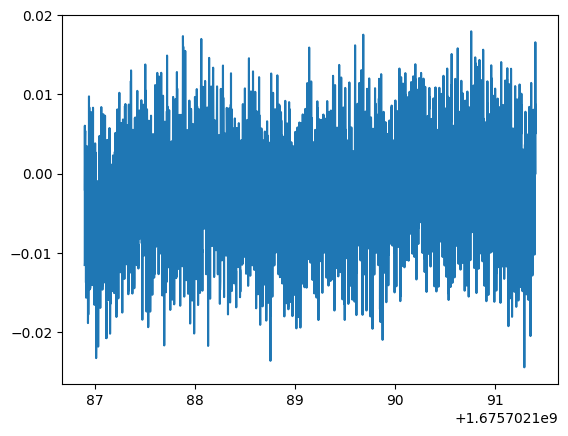

In [22]:
hdf5_path='m000000'
parental_name='meta'
name='sweeps'
delay_time = .1
mean_fetch_time = .7
amplitude = .3
frequency = 1
sweep_counts = 5
max_current = .3
amplification_sample = 100
amplification_reference = 100
reference_resistance = 4.7E4
bin_min=0
bin_max=0
bin_points=0
exclusion_voltage=3.4E-4*5

from time import time, sleep


def get_dataset(dgw, tic, toc, multi_keyword, hdf5_path='m000000'):
    # TODO slices
    path = f"/measurement/{hdf5_path}/multi_{multi_keyword}/"
    while dgw.get_data(path, indices=slice(-1, None, None), field='time')[0] < toc:
        sleep(.1)
    multi = dgw.get_data(path, indices=slice(-5000, None, None))
    time, V = multi['time'], multi['V']
    indices = np.argmin(np.abs(time-tic)), np.argmin(np.abs(time-toc))
    return time[indices[0]:indices[1]], V[indices[0]:indices[1]]

tic = time()
tic = tic - delay_time
toc = tic + sweep_counts / frequency + 2 * delay_time
sleep(sweep_counts / frequency + mean_fetch_time)

# get data from dgw
ref_t, ref_V = get_dataset(dgw, tic, toc, 
                            multi_keyword='reference',
                            hdf5_path=hdf5_path)

plt.plot(ref_t, ref_V)

(1675702093.2298033, 1675702093.2298033)

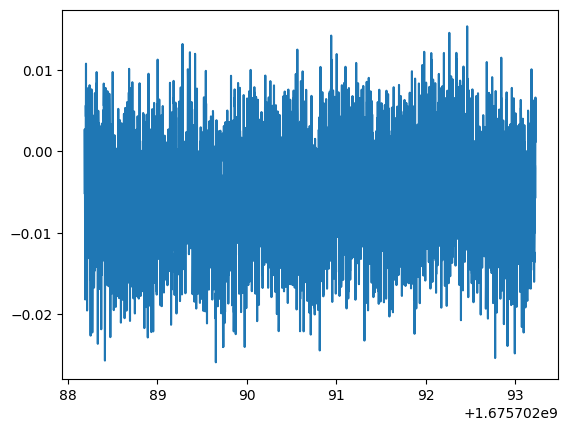

In [20]:
import matplotlib.pyplot as plt
path = f"/measurement/{hdf5_path}/multi_reference/"
multi = dgw.get_data(path, indices=slice(-5000, None, None))
plt.plot(multi['time'], multi['V'])
np.shape(multi['time']), np.shape(multi['V'])



multi = dgw.get_data(path, indices=slice(-5000, None, None))

multi['time'][-1], dgw.get_data(path, indices=slice(-1, None, None), field='time')[0]

In [5]:
binned_voltage, binned_current_upsweep, binned_current_downsweep = sweep_measurement(gw, dgw, 
                        hdf5_path='m000000', parental_name='meta', name='sweeps',
                        delay_time = .1, mean_fetch_time = .7,
                        amplitude = .3, frequency = 1, 
                        sweep_counts = 5, max_current = .3,
                        amplification_sample = 100,
                        amplification_reference = 100,
                        reference_resistance = 4.7E4,
                        bin_min=0, bin_max=0, bin_points=0,
                        exclusion_voltage=3.4E-4*5)

5155 5156 5153
(2480,) (2480,)


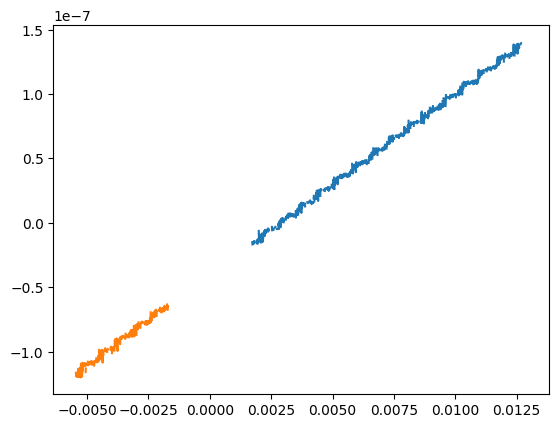

In [11]:
%matplotlib inline
exclusion_voltage=3.4E-4*5
import matplotlib.pyplot as plt
_logic_binned_min = (binned_voltage <= -exclusion_voltage)
_logic_binned_max = (binned_voltage >= exclusion_voltage)
# print(_logic_binned_min, _logic_binned_max)
binned_voltage_excluded_max = binned_voltage[_logic_binned_max]
binned_voltage_excluded_min = binned_voltage[_logic_binned_min]
binned_current_upsweep_excluded_max = binned_current_upsweep[_logic_binned_max]
binned_current_upsweep_excluded_min = binned_current_upsweep[_logic_binned_min]
# print(np.shape(binned_voltage_excluded_max), np.shape(binned_voltage_excluded_min))
# print(binned_voltage_excluded_max, binned_voltage_excluded_min)

plt.plot(binned_voltage_excluded_max, binned_current_upsweep_excluded_max)
plt.plot(binned_voltage_excluded_min, binned_current_upsweep_excluded_min)
plt.show()
# binned_current_upsweep_excluded = binned_current_upsweep
# binned_current_downsweep_excluded = binned_current_downsweep

# binned_voltage_excluded[_logic_binned] = np.nan
# binned_current_upsweep_excluded[_logic_binned] = np.nan
# binned_current_downsweep_excluded[_logic_binned] = np.nan

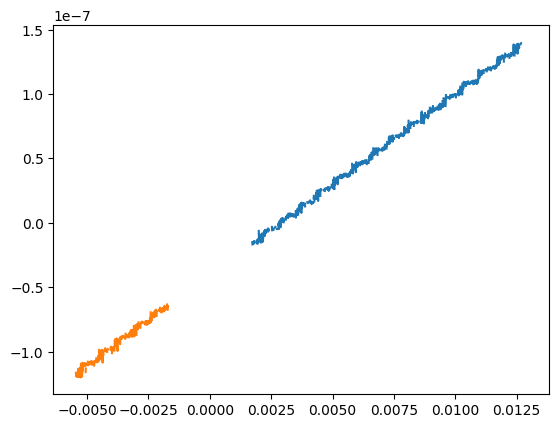

In [12]:

plt.plot(binned_voltage_excluded_max, binned_current_upsweep_excluded_max)
plt.plot(binned_voltage_excluded_min, binned_current_upsweep_excluded_min)
plt.show()

In [508]:
V, C1, C2 = binned_voltage_excluded, binned_current_upsweep_excluded, binned_current_downsweep_excluded

np.shape(V), np.shape(C1), np.shape(C2), np.shape(~np.isnan(V))

((2500,), (2500,), (2500,), (2500,))

In [509]:
def lin_fit(V, R, I_0):
    return V / R + I_0

def combined_fit(V, R, I_0_1, I_0_2):
    return np.concatenate((lin_fit(V[0],R,I_0_1), lin_fit(V[1],R,I_0_2)))

logic = ~np.isnan(V)
V = V[logic]
C1 = C1[logic]
C2 = C2[logic]
print(np.shape(V), np.shape(C1),np.shape(C2))

logic_C1 = ~np.isnan(C1)
V1 = V[logic_C1]
C1 = C1[logic_C1]
print(np.shape(V1), np.shape(C1))

logic_C2 = ~np.isnan(C2)
V2 = V[logic_C2]
C2 = C2[logic_C2]
print(np.shape(V2), np.shape(C2))


CC = np.append(C1, C2)
VV = np.append(V1, V2)

# plt.plot(np.isnan(V1))
# plt.plot(np.isnan(V2))
# plt.plot(np.isnan(C1))
# plt.plot(np.isnan(C2))

# np.shape(V), np.shape(C1), np.shape(C2)
VV = [[V1, V2]]
II = [[C1, C2]]

(a, *b), _ = curve_fit(combined_fit, V, II.ravel())
# a,b

(2039,) (2039,) (2039,)
(1248,) (1248,)
(1258,) (1258,)


AttributeError: 'list' object has no attribute 'ravel'

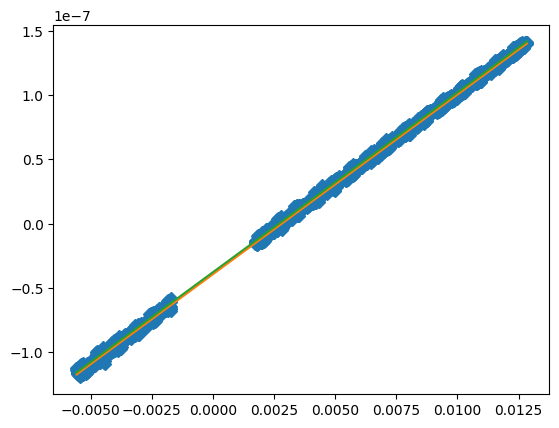

a, b, c: [ 1.40031327e-05 -3.94116369e-08 -3.77812345e-08]


In [524]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

y1 = C1
y2 = C2
comboY = np.append(y1, y2)

x1 = V1
x2 = V2
comboX = np.append(x1, x2)

if len(y1) != len(x1):
    raise(Exception('Unequal x1 and y1 data length'))
if len(y2) != len(x2):
    raise(Exception('Unequal x2 and y2 data length'))


def lin_fit_1(V, R, I_0_1, I_0_2):
        return R * V + I_0_1

def lin_fit_2(V, R, I_0_1, I_0_2):
        return R * V + I_0_2

def combinedFunction(VV, R, I_0_1, I_0_2):
    # single data reference passed in, extract separate data
    # assumes biggest jump in voltage to be dividing index
    index = np.argmax(VV[:-1]-VV[1:])
    res1 = lin_fit_1(VV[:index], R, I_0_1, I_0_2)
    res2 = lin_fit_2(VV[index:], R, I_0_1, I_0_2)
    return np.append(res1, res2)


# some initial parameter values
initialParameters = np.array([1.0, 1.0, 1.0])

# curve fit the combined data to the combined function
[R, I1, I2], pcov = curve_fit(combinedFunction, comboX, comboY)

# values for display of fitted function
a, b, c = fittedParameters

y_fit_1 = function1(x1, a, b, c) # first data set, first equation
y_fit_2 = function2(x2, a, b, c) # second data set, second equation

plt.plot(comboX, comboY, 'D') # plot the raw data
plt.plot(x1, y_fit_1) # plot the equation using the fitted parameters
plt.plot(x2, y_fit_2) # plot the equation using the fitted parameters
plt.show()

print('a, b, c:', fittedParameters)

In [525]:
R, I1, I2

(1.4003132696659477e-05, -3.9411636893491995e-08, -3.778123452288992e-08)

In [492]:
x = np.arange(4)
y = np.array([x + a + np.random.normal(0, 0.5, len(x)) for a in range(3)])
x,y, V, II
np.shape(x), np.shape(y), np.shape(V), np.shape(II)

((4,), (3, 4), (782,), (2, 782))

In [486]:
np.array(([C1,C2]))


array([[-1.15233394e-07, -1.15427198e-07, -1.17934270e-07, ...,
         1.41464767e-07,  1.40882420e-07,  1.41412372e-07],
       [-1.15445559e-07, -1.11668946e-07, -1.12230730e-07, ...,
         1.39365000e-07,  1.40527540e-07,  1.40006819e-07]])

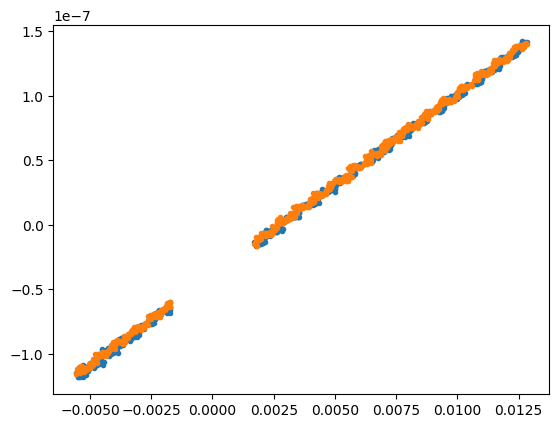

In [480]:
plt.plot(V, C1, '.')
plt.plot(V, C2, '.')

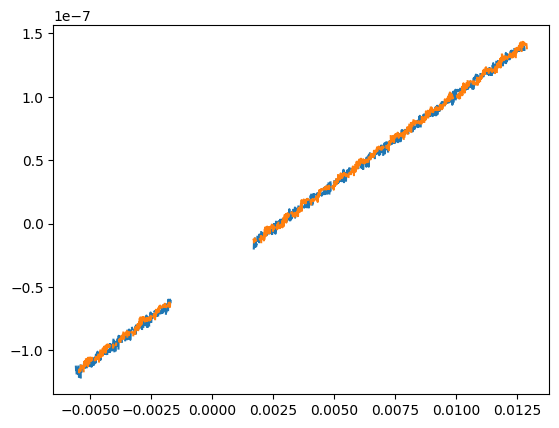

In [447]:
plt.plot(V, C1)
plt.plot(V, C2)

In [382]:
offset_measurement(gw, dgw, 
                        hdf5_path='m000000', parental_name='meta_data', name='offsets',
                        delay_time = .1, mean_fetch_time = .7,
                        offset_time = 1, max_current = .1)

# Offset Measurement
Input:
- offest_time
- max_current

Output:
- means / stds

In [340]:
mean_fetch_time = .7
delay_time = .1
offset_time = 1
max_current = .3

gw.source_bias.setup_offset_measurement(max_current=max_current)

In [341]:
from time import sleep, time

if delay_time != 0:
    sleep(delay_time)
tic = time()
toc = tic + offset_time
sleep(offset_time+mean_fetch_time)


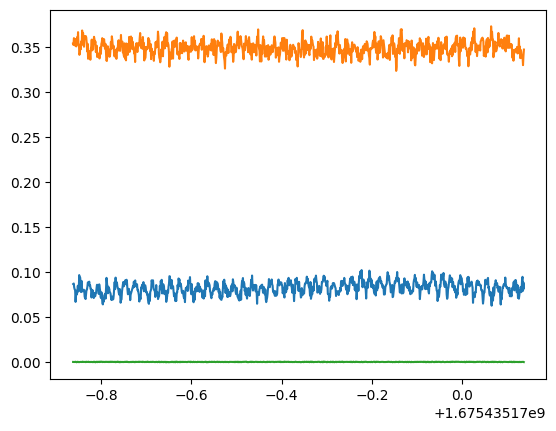

In [342]:
import numpy as np

def get_dataset(dgw, tic, toc, multi_keyword, parent_folder='m000000'):
    # TODO slices
    multi = dgw.get_data(f"/measurement/{parent_folder}/multi_{multi_keyword}/")
    time, V = multi['time'], multi['V']
    indices = np.argmin(np.abs(time-tic)), np.argmin(np.abs(time-toc))
    return time[indices[0]:indices[1]], V[indices[0]:indices[1]]

nu_ref_time, nu_ref_V = get_dataset(dgw, tic, toc, multi_keyword='reference')
nu_sample_time, nu_sample_V = get_dataset(dgw, tic, toc, multi_keyword='sample')
nu_source_time, nu_source_V = get_dataset(dgw, tic, toc, multi_keyword='source')

import matplotlib.pyplot as plt
plt.plot(nu_ref_time, nu_ref_V)
plt.plot(nu_sample_time, nu_sample_V)
plt.plot(nu_source_time, nu_source_V)


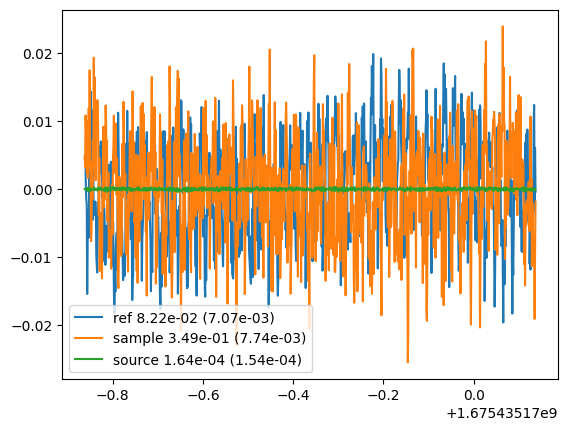

In [343]:
offset_source = np.mean(nu_source_V)
offset_sample = np.mean(nu_sample_V)
offset_ref = np.mean(nu_ref_V)

std_source = np.std(nu_source_V)
std_sample = np.std(nu_sample_V)
std_ref = np.std(nu_ref_V)

import numpy as np
import matplotlib.pyplot as plt
plt.plot(nu_ref_time, nu_ref_V-offset_ref, label = f"ref {offset_ref:.2e} ({std_ref:.2e})")
plt.plot(nu_sample_time, nu_sample_V-offset_sample, label = f"sample {offset_sample:.2e} ({std_sample:.2e})")
plt.plot(nu_source_time, nu_source_V-offset_source, label = f"source {offset_source:.2e} ({std_source:.2e})")
plt.legend()

# Sweep Measurement

In [344]:
mean_fetch_time = .7
delay_time = .1

amplitude = .25
frequency = 1
max_current = .3
sweep_counts = 10

gw.source_bias.setup_sweep_measurement(amplitude = amplitude,
                                        frequency = frequency,
                                        sweep_counts = sweep_counts, 
                                        max_current = max_current)

In [345]:
from time import sleep, time
tic = time()
gw.source_bias.trigger_measurment()
tic = tic - delay_time
toc = tic + sweep_counts / frequency + 2 * delay_time
sleep(sweep_counts / frequency + mean_fetch_time)

In [346]:
import numpy as np

def get_dataset(dgw, tic, toc, multi_keyword, parent_folder='m000000'):
    # TODO slices
    multi = dgw.get_data(f"/measurement/{parent_folder}/multi_{multi_keyword}/")
    time, V = multi['time'], multi['V']
    indices = np.argmin(np.abs(time-tic)), np.argmin(np.abs(time-toc))
    return time[indices[0]:indices[1]], V[indices[0]:indices[1]]

nu_ref_time, nu_ref_V = get_dataset(dgw, tic, toc, multi_keyword='reference')
nu_sample_time, nu_sample_V = get_dataset(dgw, tic, toc, multi_keyword='sample')
nu_source_time, nu_source_V = get_dataset(dgw, tic, toc, multi_keyword='source')

In [349]:
from scipy.signal import savgol_filter as sg
from scipy.signal import find_peaks as fp

def get_min_max_peaks(V, t, frequency, sweep_counts):
    window_length = int(10/frequency)
    smooth_V = sg(V, window_length=window_length, polyorder=1)
    dV = np.gradient(smooth_V)
    smooth_dV = sg(dV, window_length=window_length, polyorder=1)
    ddV = np.gradient(smooth_dV)
    smooth_ddV = sg(ddV, window_length=window_length, polyorder=1)

    symmetrical_ddV = smooth_ddV - np.mean(smooth_ddV)

    min_peaks = fp(symmetrical_ddV, height=.25*np.nanmax(symmetrical_ddV), distance=2*window_length)[0]
    max_peaks = fp(-symmetrical_ddV, height=.25*np.nanmax(symmetrical_ddV), distance=2*window_length)[0]

    min_peaks = [1,2,3]
    max_peaks = [1,2,3]
    if len(min_peaks) == len(max_peaks):
        min_peaks = np.append(min_peaks, [-1])
    return min_peaks, max_peaks

min_peaks, max_peaks = get_min_max_peaks(nu_source_V, nu_source_time, frequency, sweep_counts)

# smooth_0 = sg(nu_source_V, window_length=int(10/freq), polyorder=1)
# first = np.gradient(smooth_0) 
# smooth_1 = sg(first, window_length=int(10/freq), polyorder=1)
# second_order = np.gradient(smooth_1)
# smooth_2 = sg(second_order, window_length=int(10/freq), polyorder=1)
# smooth_2_abs = smooth_2
# smooth_2_abs = smooth_2_abs-np.mean(smooth_2_abs)
# min_peaks = fp(smooth_2_abs, height=.25*np.nanmax(smooth_2_abs), distance=20/(freq))
# max_peaks = fp(-smooth_2_abs, height=.25*np.nanmax(smooth_2_abs), distance=20/(freq))
# np.shape(max_peaks[0])[0] +np.shape(min_peaks[0])[0] == count*2+1

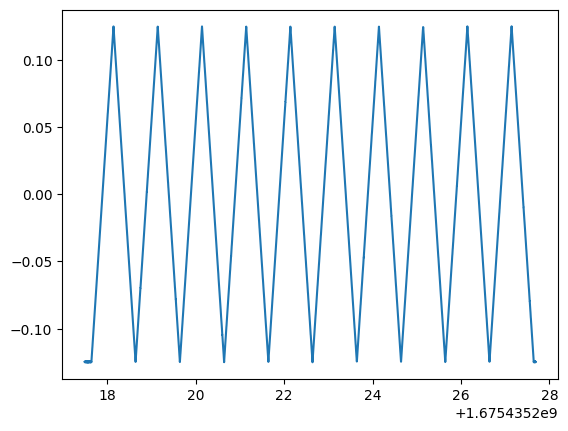

In [350]:
import numpy as np
import matplotlib.pyplot as plt
# plt.plot(nu_ref_time, nu_ref_V)
# plt.plot(nu_sample_time, nu_sample_V)
plt.plot(nu_source_time, nu_source_V)

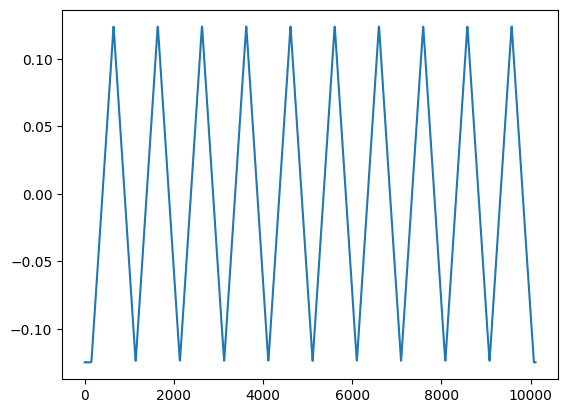

In [351]:
from scipy.signal import savgol_filter as sg
smooth_0 = sg(nu_source_V, window_length=int(10/freq), polyorder=1)
plt.plot(smooth_0)

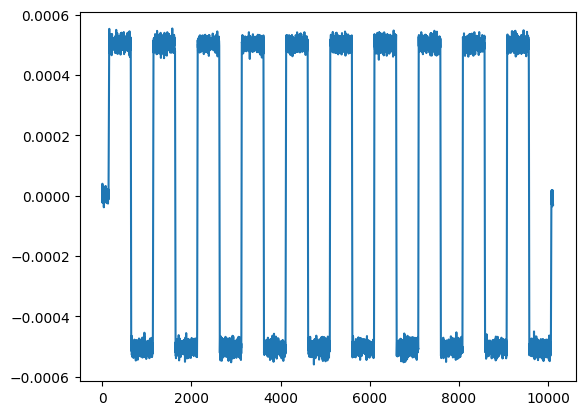

In [229]:

first = np.gradient(smooth_0) #sg(np.gradient(nu_source_V), window_length=int(nu_source_len/(10*count)), polyorder=1)
plt.plot(first)

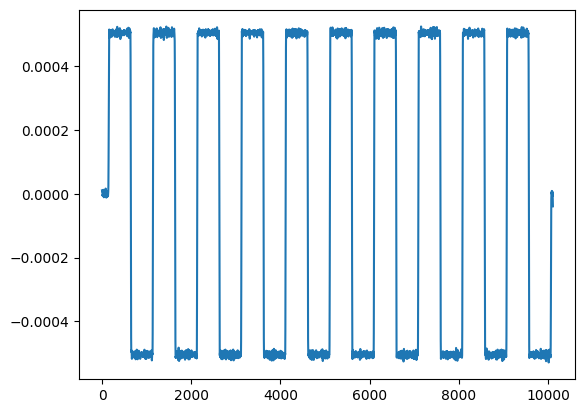

In [230]:
smooth_1 = sg(first, window_length=int(10/freq), polyorder=1)
plt.plot(smooth_1)

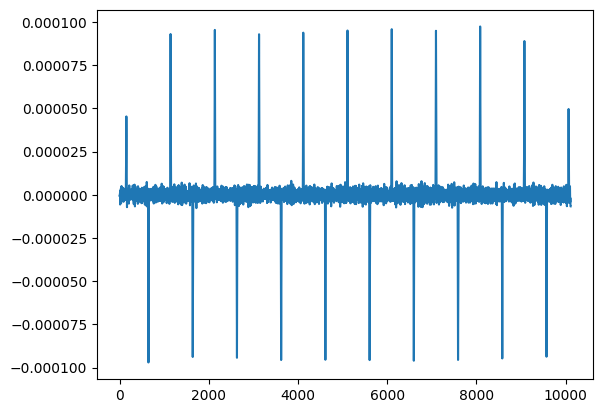

In [231]:
second_order = np.gradient(smooth_1)
plt.plot(second_order)

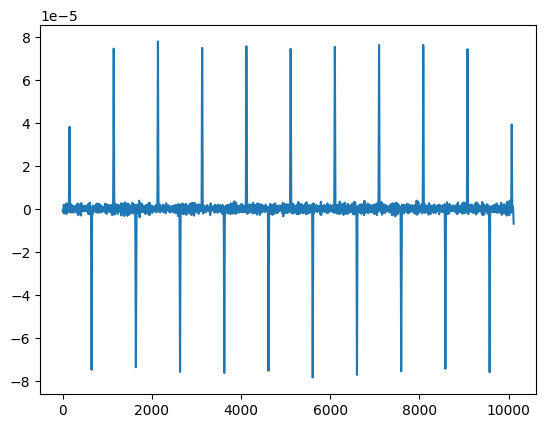

In [232]:
smooth_2 = sg(second_order, window_length=int(10/freq), polyorder=1)
plt.plot(smooth_2)

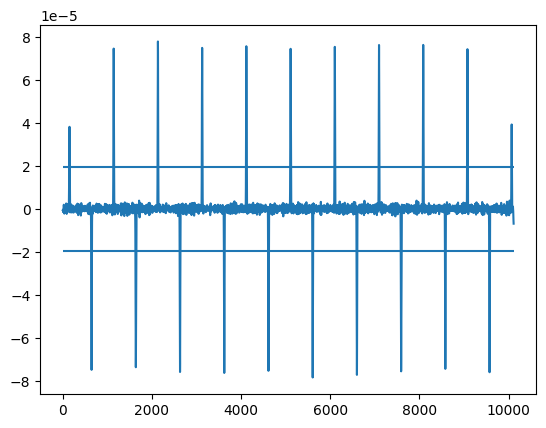

In [233]:
smooth_2_abs = smooth_2
smooth_2_abs = smooth_2_abs-np.mean(smooth_2_abs)
plt.plot(smooth_2_abs)
plt.hlines(.25*np.nanmax(smooth_2_abs), 0, nu_source_len)
plt.hlines(-.25*np.nanmax(smooth_2_abs), 0, nu_source_len)
# plt.xlim(0,100)

In [234]:
from scipy.signal import find_peaks as fp

In [235]:
from scipy.signal import find_peaks as fp
min_peaks = fp(smooth_2_abs, height=.25*np.nanmax(smooth_2_abs), distance=20/(freq))
max_peaks = fp(-smooth_2_abs, height=.25*np.nanmax(smooth_2_abs), distance=20/(freq))
np.shape(max_peaks[0])[0] +np.shape(min_peaks[0])[0] == count*2+1

True

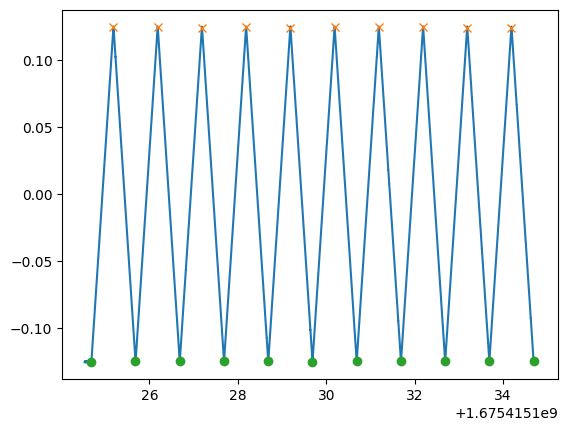

In [236]:

plt.plot(nu_source_time,nu_source_V, "-")
plt.plot(nu_source_time[max_peaks[0]], nu_source_V[max_peaks[0]], "x")
plt.plot(nu_source_time[min_peaks[0]], nu_source_V[min_peaks[0]], "o")
#plt.xlim(40,60)

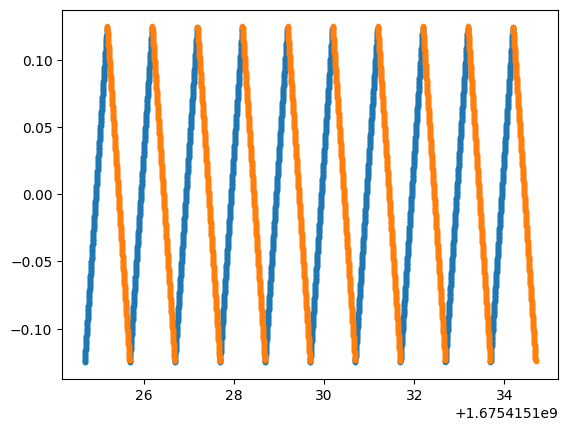

In [285]:
def get_up_down_sweep(array, min, max):
    up = np.array([])
    down = np.array([])
    for i, p in enumerate(max):
        # print(i,p)
        up = np.append(up, array[min[i]:p])
        down = np.append(down, array[p:min[i+1]])
    return up, down

source_upsweep_V, source_downsweep_V = get_up_down_sweep(nu_source_V, min_peaks[0], max_peaks[0])
sample_upsweep_V, sample_downsweep_V = get_up_down_sweep(nu_sample_V, min_peaks[0], max_peaks[0])
ref_upsweep_V, ref_downsweep_V = get_up_down_sweep(nu_ref_V, min_peaks[0], max_peaks[0])

source_upsweep_t, source_downsweep_t = get_up_down_sweep(nu_source_time, min_peaks[0], max_peaks[0])
sample_upsweep_t, sample_downsweep_t = get_up_down_sweep(nu_sample_time, min_peaks[0], max_peaks[0])
ref_upsweep_t, ref_downsweep_t = get_up_down_sweep(nu_ref_time, min_peaks[0], max_peaks[0])

plt.plot(source_upsweep_t,source_upsweep_V,'.')
plt.plot(source_downsweep_t,source_downsweep_V,'.')

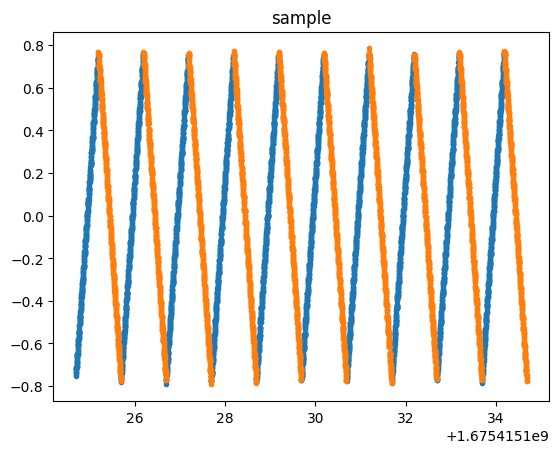

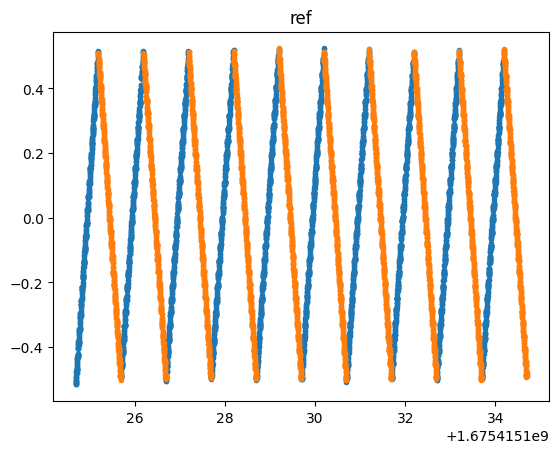

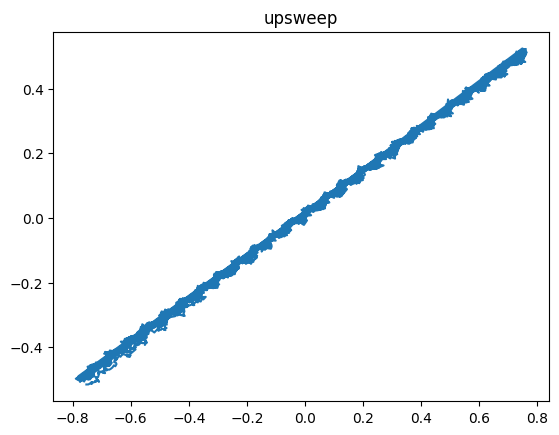

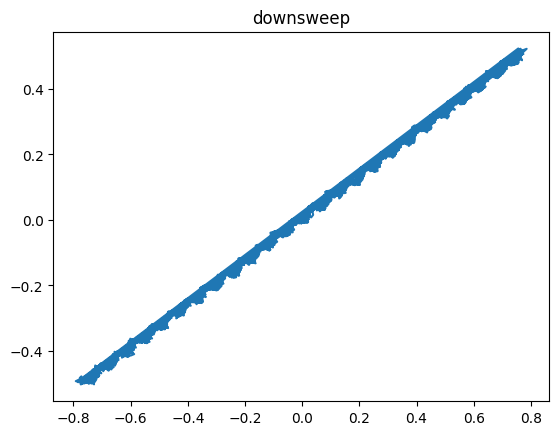

In [290]:
plt.figure(0)
plt.title('sample')
plt.plot(sample_upsweep_t,sample_upsweep_V,'.')
plt.plot(sample_downsweep_t,sample_downsweep_V,'.')

plt.figure(1)
plt.title('ref')
plt.plot(ref_upsweep_t,ref_upsweep_V,'.')
plt.plot(ref_downsweep_t,ref_downsweep_V,'.')

plt.figure(2)
plt.title('upsweep')
plt.plot(sample_upsweep_V, ref_upsweep_V)

plt.figure(3)
plt.title('downsweep')
plt.plot(sample_downsweep_V, ref_downsweep_V)

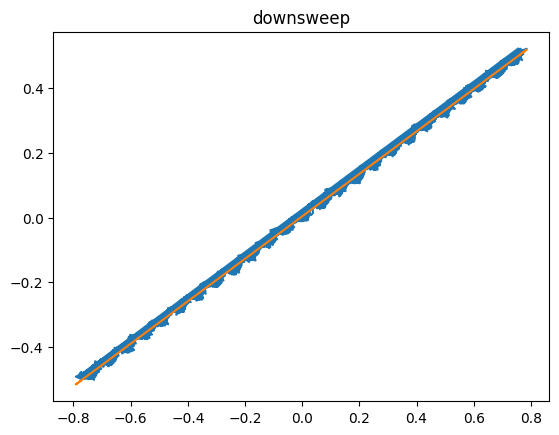

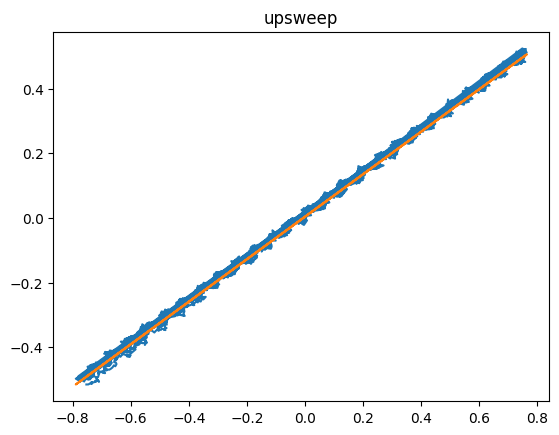

In [297]:
from scipy.optimize import curve_fit

def lin_fit(x, a,b):
    return a*x+b

popt_down, pcov_down = curve_fit(lin_fit, sample_downsweep_V, ref_downsweep_V, )

plt.figure(3)
plt.title('downsweep')
plt.plot(sample_downsweep_V, ref_downsweep_V)
plt.plot(sample_downsweep_V, lin_fit(sample_downsweep_V, *popt))


popt_up, pcov_up = curve_fit(lin_fit, sample_upsweep_V, ref_upsweep_V, )

plt.figure(4)
plt.title('upsweep')
plt.plot(sample_upsweep_V, ref_upsweep_V)
plt.plot(sample_upsweep_V, lin_fit(sample_upsweep_V, *popt))

(5000,)
(5001,)
(5000,)


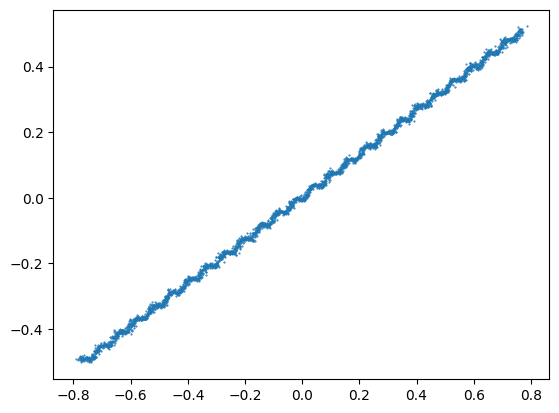

In [405]:
my_bins = np.linspace(np.nanmin(sample_downsweep_V),
                   np.nanmax(sample_downsweep_V),
                   int(10*.5/freq*1000))
print(np.shape(my_bins))
my_bins = np.append(my_bins, 2 * my_bins[-1] - my_bins[-2])
print(np.shape(my_bins))

count, _ = np.histogram(sample_downsweep_V, bins = my_bins, weights=None)
count = np.array(count, dtype='float64')
count[count==0] = np.nan
sum, _ = np.histogram(sample_downsweep_V, bins =my_bins, weights=ref_downsweep_V)
# iSUM, x_edges, y_edges = np.histogram(X, Y, bins=resolution, range=extents, normed=False, weights=Z)
# iCOUNT, x_edges, y_edges = np.histogram(X, Y, bins=resolution, range=extents, normed=False, weights=None)
plt.plot(my_bins[:-1], sum/count,'.', ms=1)
print(np.shape(sum/count))

In [399]:
my_bins = np.linspace(np.nanmin(sample_downsweep_V),
                   np.nanmax(sample_downsweep_V),
                   int(10*.5/freq*1000))
my_bins = np.append(my_bins, 2 * my_bins[-1] - my_bins[-2])

In [407]:
exclusion_voltage=3.4E-4*5
exclusion_voltage

0.0017000000000000001

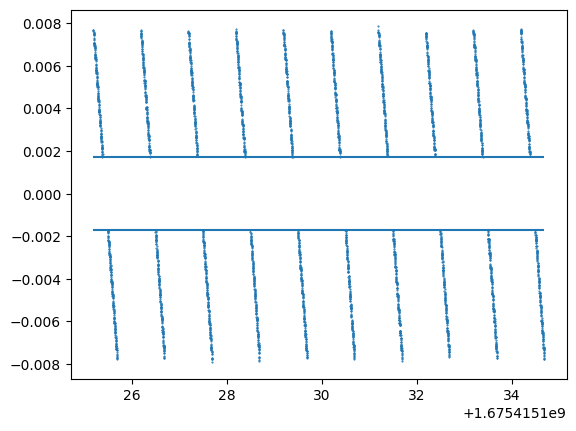

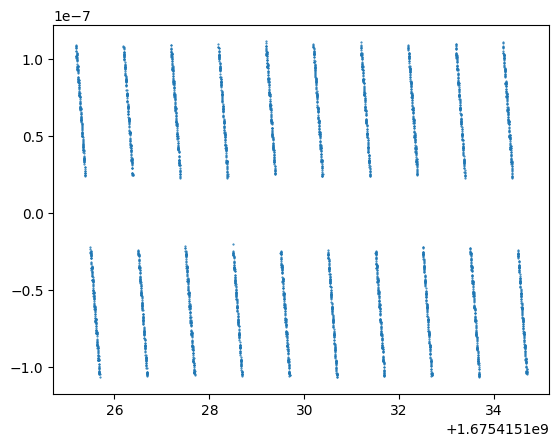

In [419]:
voltage = sample_downsweep_V/100
current = ref_downsweep_V/100/4.7e4
logic = np.abs(voltage)<= exclusion_voltage
voltage[logic] = np.nan
current[logic] = np.nan

plt.figure(0)
plt.plot(sample_downsweep_t, voltage, '.', ms=1)
plt.hlines(exclusion_voltage, np.min(sample_downsweep_t), np.max(sample_downsweep_t))
plt.hlines(-exclusion_voltage, np.min(sample_downsweep_t), np.max(sample_downsweep_t))


plt.figure(1)
plt.plot(ref_downsweep_t, current, '.', ms=1)
# plt.hlines(exclusion_voltage, np.min(sample_downsweep_t), np.max(sample_downsweep_t))
# plt.hlines(-exclusion_voltage, np.min(sample_downsweep_t), np.max(sample_downsweep_t))

## OFFSET
### Input
- duration
### Output
- Offsets
- Noice

## SWEEP
### Input
- messung: offsets
- verstärkungen
- rref
- source: sweep_count / freq / ampl
- binning parameter: min, max, bin_count

### Output
- up / down sweep
    - I/V Characteristic (arrayI, linspaceV)
    - dG 
    - R Werte (lin, max, rms)

# Multimeter update time messen

(array([0.00000000e+00, 1.07479095e-03, 5.90312481e-01, ...,
        3.89018880e+03, 3.89074336e+03, 3.89074437e+03]),
 array([0.05, 0.05, 0.05, ..., 0.45, 0.05, 0.05]))

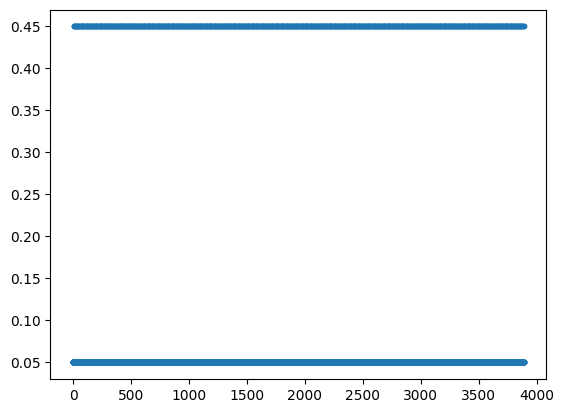

In [160]:
first_order = np.abs(np.gradient(multi_source['trig']))
time = multi_source['time']

first_order[first_order<=0.025] = np.nan
time[np.isnan(first_order)] = np.nan

first_order = first_order[~np.isnan(first_order)]
time = time[~np.isnan(time)]
time = time - float(time[0])

plt.plot(time,first_order,'.')
time, first_order

In [171]:
diff = time[1:]-time[:-1]
# diff[diff<=.3]=np.nan

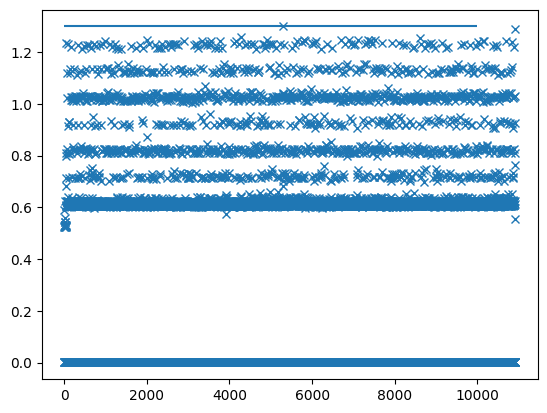

In [172]:
plt.plot(diff, 'x')
plt.hlines(np.nanmax(diff), 0, 10000)

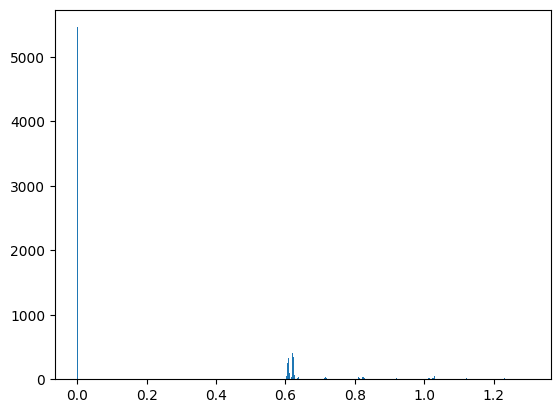

In [175]:
solutions = plt.hist(diff, bins=1000)

In [183]:
solutions[0]

diff2 = solutions[0]
diff2[0]=0
diff2[(diff2)==0]=np.nan

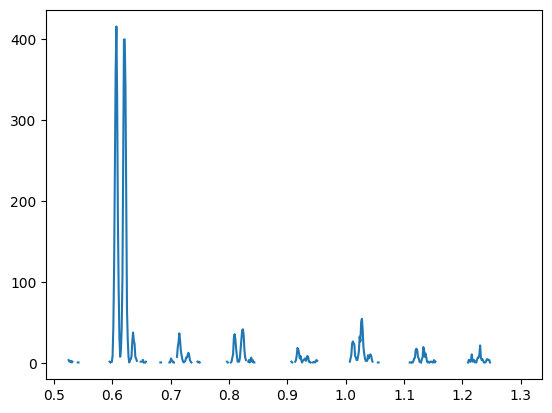

In [184]:
plt.plot(solutions[1][:-1],diff2)

# Multimeter updaten meistens nach 0.7s